In [61]:
# Load packages and functions
exec(open('topoaware.py').read())

In [114]:
# Load test data
df = pd.read_csv('../examples/test_shape.csv')
x = df['x'].values[:take]
y = df['y'].values[:take]
dataset = df.values[:take]

# Set parameters
take = 500
diameter = np.max([np.max(x)-np.min(x),np.max(y)-np.min(y)])
radius = .2*diameter
sparsification_distance = .02*diameter

In [115]:
# If necessary, sparsify before applying any functions
# Useful when dataset has large density variance
print('Sparsifying input...',end=' ',flush=True)
t0 = default_timer()

dataset = subs.sparsify_point_set(points=dataset, min_squared_dist=(sparsification_distance)**2)
x = np.array(dataset).T[0]
y = np.array(dataset).T[1]

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Sparsifying input... done in 0.01 seconds


In [116]:
# Construct Vietoris--Rips complex on shape
print('Constructing Vietoris--Rips complex...',end=' ',flush=True)
t0 = default_timer()

complex_vr_container = gd.RipsComplex(points=dataset, max_edge_length=radius)
complex_vr = complex_vr_container.create_simplex_tree(max_dimension=2)

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Constructing Vietoris--Rips complex... done in 0.01 seconds


In [117]:
# Get barycenters
print('Computing barycenters of simplices...',end=' ',flush=True)
t0 = default_timer()

bc = barycenters(complex_vr, dataset)

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Computing barycenters of simplices... done in 1.13 seconds


In [118]:
# Sparsify
print('Sparsifying...',end=' ',flush=True)
t0 = default_timer()

sp = subs.sparsify_point_set(points=bc.tolist(),min_squared_dist=(sparsification_distance)**2)
xsp = np.array(sp).T[0]
ysp = np.array(sp).T[1]

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Sparsifying... done in 0.15 seconds


In [119]:
# Construct Delaunay complex
print('Constructing Delaunay complex...',end=' ',flush=True)
t0 = default_timer()

complex_alpha_container = gd.AlphaComplex(sp)
complex_alpha = complex_alpha_container.create_simplex_tree(max_alpha_square=(radius/2)**2)

t1 = default_timer()
print(f"done in {np.round(t1-t0,2)} seconds")

Constructing Delaunay complex... done in 0.01 seconds


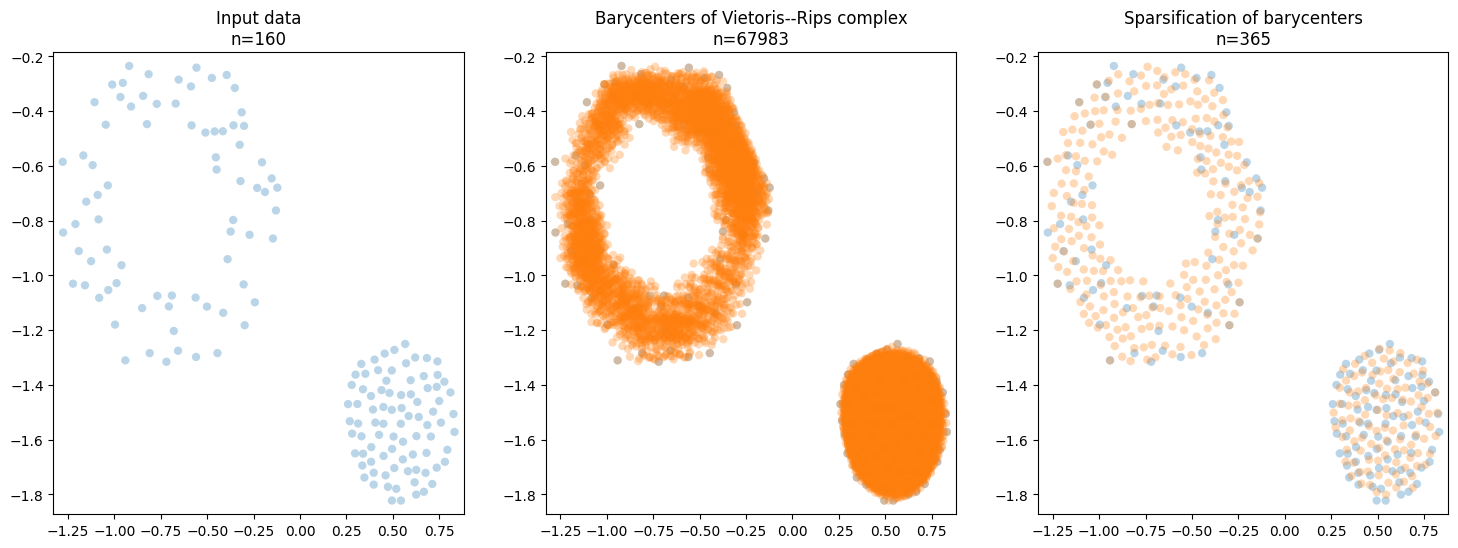

In [120]:
# Visualize data
fig,axes = plt.subplots(1,3,figsize=(18,6))

kwds = {'alpha':.3, 'ec':'None'}

ax = axes[0]
ax.set_title(f"Input data\nn={x.shape[0]}")
ax.scatter(x,y,**kwds)

ax = axes[1]
ax.set_title(f"Barycenters of Vietoris--Rips complex\nn={bc.shape[0]}")
ax.scatter(x,y,**kwds)
ax.scatter(bc.T[0], bc.T[1], **kwds)

ax = axes[2]
ax.set_title(f"Sparsification of barycenters\nn={len(sp)}")
ax.scatter(x,y,**kwds)
ax.scatter(xsp,ysp,**kwds)

for ax in axes:
    ax.set_xlim([np.min(x)-.05,np.max(x)+.05])
    ax.set_ylim([np.min(y)-.05,np.max(y)+.05])

plt.show()

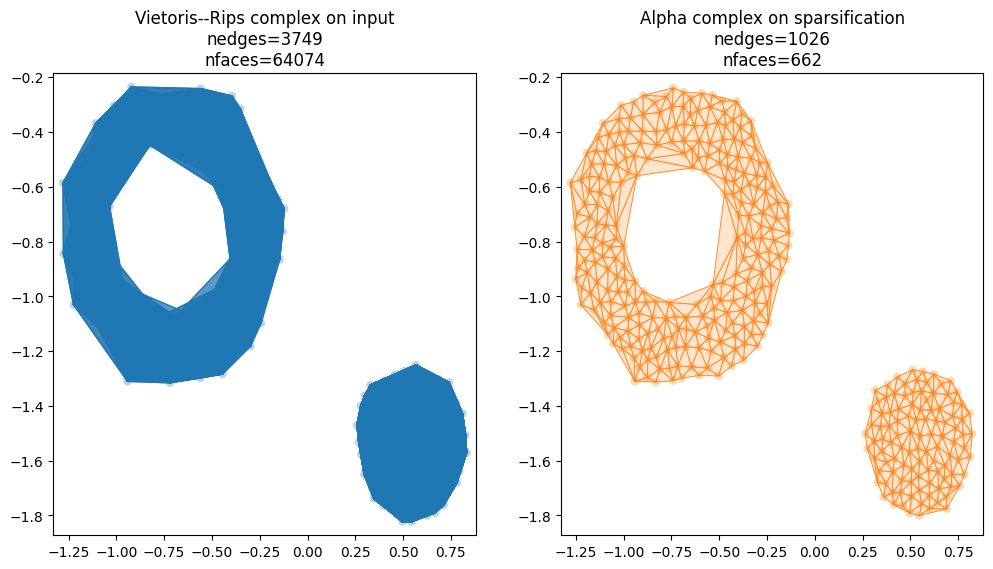

In [121]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

# Visualize simplicial complexes
fig,axes = plt.subplots(1,2,figsize=(12,6))

kwds_pts = {'alpha':.3, 'ec':'None'}

ax = axes[0]
ax.scatter(x,y,**kwds_pts)
dim2simplices_vr = []
ecount = 0; fcount = 0
for s in complex_vr.get_simplices():
    if len(s[0]) == 2:
        ax.plot([x[s[0][0]],x[s[0][1]]], [y[s[0][0]],y[s[0][1]]], c='C0', lw=.5)
        ecount += 1
    elif len(s[0]) == 3:
        dim2simplices_vr.append(Polygon([[x[s[0][0]],y[s[0][0]]], [x[s[0][1]],y[s[0][1]]], [x[s[0][2]],y[s[0][2]]]], closed=True))
        fcount += 1
ax.add_collection(PatchCollection(dim2simplices_vr, alpha=.2, color='C0'))
ax.set_title(f"Vietoris--Rips complex on input\nnedges={ecount}\nnfaces={fcount}")

ax = axes[1]
ax.scatter(np.array(sp).T[0], np.array(sp).T[1], **kwds_pts, c='C1')
dim2simplices_alpha = []
ecount = 0; fcount = 0
for s in complex_alpha.get_simplices():
    if len(s[0]) == 2:
        ax.plot([xsp[s[0][0]],xsp[s[0][1]]], [ysp[s[0][0]],ysp[s[0][1]]], c='C1', lw=.5)
        ecount += 1
    elif len(s[0]) == 3:
        dim2simplices_alpha.append(Polygon([[xsp[s[0][0]],ysp[s[0][0]]], [xsp[s[0][1]],ysp[s[0][1]]], [xsp[s[0][2]],ysp[s[0][2]]]], closed=True))
        fcount += 1
ax.add_collection(PatchCollection(dim2simplices_alpha, alpha=.2, color='C1'))
ax.set_title(f"Alpha complex on sparsification\nnedges={ecount}\nnfaces={fcount}")

for ax in axes:
    ax.set_xlim([np.min(x)-.05,np.max(x)+.05])
    ax.set_ylim([np.min(y)-.05,np.max(y)+.05])

plt.show()